<h1><center><b> Named Entity Recognition </b></center></h1>

#### NER is used for extraction such entities from the text as persons, organizations, locations, etc. Here we try to recognize named entities from Twitter with LSTMs

#### Here we will use a recurrent neural network model which will be made using KERAS Sequentional API to solve our NER problem

In [1]:
# Hide tensorflow warnings
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [17]:
# Libraries needed

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Dropout, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

#### Note: Sometimes we have to run the above cell for importing libraries again as tensorflow or keras module is unable to get imported the first time due to some bug. If later on, if we get an error when compiling our mode or our settings optimizers etc, re-run the import library cell again.
#### Note: Tensorflow 2.5 and numpy 1.20 and 1.21 will result in an error when building the model as Tensforflow uses numpy ver 1.19.5 internally for calculations.  

In [3]:
# Note: 'with' automatically closes file 

with open('data/train.txt') as f:
    line = [f.readline() for i in range(100)]
    print(line)

['RT O\n', '@TheValarium O\n', ': O\n', 'Online O\n', 'ticket O\n', 'sales O\n', 'for O\n', 'Ghostland B-musicartist\n', 'Observatory I-musicartist\n', 'extended O\n', 'until O\n', '6 O\n', 'PM O\n', 'EST O\n', 'due O\n', 'to O\n', 'high O\n', 'demand O\n', '. O\n', 'Get O\n', 'them O\n', 'before O\n', 'they O\n', 'sell O\n', 'out O\n', '... O\n', '\n', 'Apple B-product\n', 'MacBook I-product\n', 'Pro I-product\n', 'A1278 I-product\n', '13.3 I-product\n', '" I-product\n', 'Laptop I-product\n', '- I-product\n', 'MD101LL/A I-product\n', '( O\n', 'June O\n', ', O\n', '2012 O\n', ') O\n', '- O\n', 'Full O\n', 'read O\n', 'by O\n', 'eBay B-company\n', 'http://t.co/2zgQ99nmuf O\n', 'http://t.co/eQmogqqABK O\n', '\n', 'Happy O\n', 'Birthday O\n', '@AshForeverAshey O\n', '! O\n', 'May O\n', 'Allah B-person\n', 's.w.t O\n', 'bless O\n', 'you O\n', 'with O\n', 'goodness O\n', 'and O\n', 'happiness O\n', '. O\n', '\n', '@AqwSkills O\n', 'the O\n', 'quest O\n', 'line O\n', 'im O\n', 'assuming O\n'

#### Reading twitter text file format, we note every line contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace and different tweets are separated by an empty line. 

#### Further, we see different user names start after an '@' symbol and also there are different url's. These can be replaced by an identification token as they won't be useful by themselves in our model.

In [4]:
""" Function to read twitter text file and return a separated list of tokens and its corresponding tags """

def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token

            if token.startswith("@"):
                token="<USR>"
            elif token.startswith("http://") or token.startswith("https://"):
                token="<URL>"
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

In [5]:
train_tokens, train_tags = read_data('data/train.txt')
val_tokens, val_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

#### Saving our tokens and tags into train,validation and test sets.
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [6]:
for i in range(2):
    print("----- Sentence {0} :- -----".format(i+1))
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print ("----------------------- \n")

----- Sentence 1 :- -----
RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O
----------------------- 

----- Sentence 2 :- -----
Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O
----------------------- 



#### Checking our training set list for tokens and tags

-----------------------------------

# Data Pre-Processing

#### To train our neural network, we will create a dictionary with two mappings:
- token → token id: use integers as input data of KERAS embedding layer so that words can be represented     by dense vectors (More memory and computationally efficient than One-Hot Encoding)
- tag → tag id: use integers for computing the loss at the output of the network.

#### Note: Here we are considering that we have single-class labels, where an object can only belong to one class, i.e. each token belongs to a particular tag or vice-versa. Hence, we can use "sparse_categorical_crossentropy" instead of "categorical_crossentropy" as our loss function which requires one-hot-encoded vectors

#### Note: We will also need to add some 'Special tokens and tags' to our dictionary. They will be unknown tokens and padding tokens/tags.
- &lt;UNK&gt; token to represent of vocabulary tokens;
- &lt;PAD&gt; tokens and tags for padding sentence to the same length when we create batches of sentences

In [7]:
""" Dictionary to create mappings for tokens and tags """

def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
# Note: First add special tokens and tags to the dictionaries and the first special token must have index 0
# Here, first special token must be for "pad" as later on we can use an in-built KERAS function for masking
# pads to avoid extra copmutations i.e. mask_zero which only applies for value 0 (index 0 here)
    
    k = 0
    for line in special_tokens:
        tok2idx[line] = k
        k += 1
        idx2tok.append(line)
        
    for tokens in tokens_or_tags:
        for token in tokens:
            if token not in tok2idx: 
                tok2idx[token] = k 
                k += 1
                idx2tok.append(token)
    
    return tok2idx, idx2tok

In [8]:
special_tokens = ['<PAD>', '<UNK>']
special_tags = ['<PAD>']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + val_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags + val_tags , special_tags)

####  Implemented the function build_dict and creating dictionaries for our tokens and tags.
#### Note: We always consider test tokens and tags to be unseen/unknown and hence don't use them when creating our dicitonaries.

## Padding Input Sentences

#### The LSTM layers only accepts sequences within a batch that are of same lengths. Here, we will work with the max length of the longest sentence (sequence) and pad the shorter sentences (sequences) to achieve this. Thus all batches of input data will be of the same length. 

#### Note: This will not be as efficient in comparison to bucketing technique(varying input lengths) but for sake for simplicity we will use this. 

#### To use bucketing technique we will have to set our 'input_length' params in 'Embedding' layer to 'None'. However, it will fail in a scenario where we decide to flatten and dense our layers later as sequentional API requires constant input_length when the param is set to 'None' (In this scenario we can use Functional API). Also, note this problem is more common in ConvNets as they are multidimensional(except Conv1d) and Dense layers require 1-D data at all times. 

In [9]:
maxlen = max([len(s) for s in (train_tokens + val_tokens)])

""" Function for adding pads to all sentences so as to make all of them of equal length """

def pad_data(data, mapper, maxlen = maxlen, padding = "post"):
    
    """ 'data' refers to the dataset which we want to pad. e.g train_tokens
    'mapper' refers to string input whether dataset is tokens or tags. e.g "tokens"
    'maxlen' refers to max length of the sentence from batch that we want to set as references for padding
    'padding' refers to the position where we want to pad.    
    """
    
    if mapper == 'tokens':
        seq_list = [[token2idx[w] for w in s] for s in data]
        pad = pad_sequences(maxlen = maxlen, sequences = seq_list, padding = "post", value = token2idx["<PAD>"])
    else:
        seq_list = [[tag2idx[w] for w in s] for s in data]
        pad = pad_sequences(maxlen = maxlen, sequences = seq_list, padding = "post", value = tag2idx["<PAD>"])
        
    return pad    

In [10]:
X_train = pad_data(train_tokens, mapper = 'tokens')
X_val = pad_data(val_tokens, mapper = 'tokens')
X_test = pad_data(test_tokens, mapper = 'tokens')

y_train = pad_data(train_tags, mapper = 'tags')
y_val = pad_data(val_tags, mapper = 'tags')
y_test = pad_data(test_tags, mapper = 'tags')


#### We have set all our tokens and corresponding tags sentences of equal length

# Implementing Model Architecture

#### We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification. We will use Keras Sequentional API to build our model.

#### 'mask_zero' param will be set to True in 'Embedding' layer so as to to avoid computations for padding tokens inside the RNN and also when computing loss function.

#### We will set 'dropout' param in our RNN layer for regularization.

#### We will use 'softmax' in our activation function for output lyer, as it will provide us a multinominal probability distribution for our multi-label classification problem

#### Our Loss Function will be "sparse_categorical_crossentropy" (No need for OHC, can use integers)

#### Note: We can use 'Time Distributed Layer'(Many to Many architecture) instead of 'Dense Layer'(Many to One architecture) as output layer and check its performance.  

#### The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

- input_dim: This is the size of the vocabulary in the text data. Here, it will length of token dictionary   consisting of 
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of   the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger.       Here, we will use 200.
- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. Here, it will max sentence length from our training and validations dataset.

#### The output dense layer length should be equal to number of labels i.e. tags

In [11]:
input_dim = len(idx2token)
output_dim = 200
input_length = maxlen
num_tags = len(idx2tag)

#### Initialized input and output parameters for our model

## Setting Optimizer for our model

#### We will use adam optimization algorithm with learning rate decay. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. An initially large learning rate suppresses the network from memorizing noisy data while decaying the learning rate improves the learning of complex patterns.
#### Note: We can also use 'Adaptive Moment Estimation' instead of learning rate schedules method as it can be challenging to configure and is critical to the performance of a deep learning neural network model. 

#### We also apply clipping to eliminate exploding gradients. Here, we use 'global_clipnorm' function in KERAS which clips only gradients and not variables. Also, function 'clip_norm' clips the gradient of each weight independently of the gradients of the other weights and thus has the disadvantage of changing the descent direction, whereas with global_clipnorm the direction would remain unchanged.

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-2,
    decay_steps = 10000,
    decay_rate = 0.9)

opt = keras.optimizers.Adam(learning_rate = lr_schedule, global_clipnorm = 1.0)

## KERAS BI-LSTM Model

In [19]:
model = Sequential()

model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length = input_length, mask_zero = True))

forward_layer = keras.layers.RNN(
            keras.layers.LSTMCell(100, dropout = 0.5), return_sequences = True)
backward_layer = keras.layers.RNN(
            keras.layers.LSTMCell(100, dropout = 0.5), return_sequences = True, go_backwards = True)

model.add(Bidirectional(forward_layer, backward_layer = backward_layer))

model.add(Dense(num_tags, activation = "softmax"))

model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["Accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           4101000   
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 200)           240800    
_________________________________________________________________
dense (Dense)                (None, 41, 22)            4422      
Total params: 4,346,222
Trainable params: 4,346,222
Non-trainable params: 0
_________________________________________________________________


#### After compiling, we will train our data and conduct more experiments as needed to tune our hyperparameters, to obtain higher accuracy on the held-out validation dataset.
#### The hyperparameters for our model are :- batch_size, epochs, learning_rate params, global_clip_norm, dropout.

In [21]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val , y_val),
    batch_size = 32, 
    epochs = 5,
    verbose = 1,
)

Epoch 1/5
182/182 [==============================] - 68s 371ms/step - loss: 0.1661 - Accuracy: 0.9278 - val_loss: 0.1136 - val_Accuracy: 0.9372
Epoch 2/5
182/182 [==============================] - 59s 324ms/step - loss: 0.0724 - Accuracy: 0.9547 - val_loss: 0.1072 - val_Accuracy: 0.9395
Epoch 3/5
182/182 [==============================] - 53s 292ms/step - loss: 0.0336 - Accuracy: 0.9778 - val_loss: 0.1203 - val_Accuracy: 0.9364
Epoch 4/5
182/182 [==============================] - 54s 299ms/step - loss: 0.0178 - Accuracy: 0.9874 - val_loss: 0.1262 - val_Accuracy: 0.9362
Epoch 5/5
182/182 [==============================] - 59s 326ms/step - loss: 0.0109 - Accuracy: 0.9918 - val_loss: 0.1381 - val_Accuracy: 0.9306


#### Note: When evaluating results for each epoch, be careful to not use custom metrics (F1/F2 score) directly through keras metric function that is calculated during training(fit) as it is done on batches (not together) and might show misleading results. Keras inbuilt metrics (tensorflow 2) use specialised built-in accumulators, and the computations are made properly. However, note it is possible to use custom metrics by other methods like backend utilities, callbacks, base layer API's etc

#### We will plot the graph between the loss and number of epochs for training and validation set. To assess the number of epochs required and to avoid underfitting or overfitting, it is important to compare training and validation loss. 

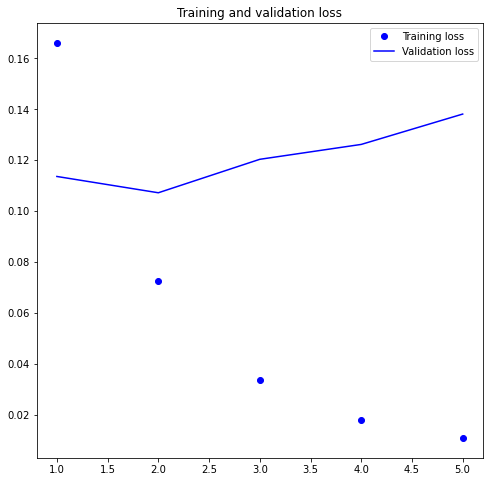

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### We observe our training loss starts becoming constant around 5 epochs and validation loss is slightly increasing. We can increase the number of epochs to check the future trend of our losses.

#### Note: We can use Callbacks to get a view on internal states and statistics of the model during training and thus help us in preventing overfitting, visualize training progress, debug your code, save checkpoints, generate logs etc. We have not used here for sake of simplicity and will demonstrate in later parts.

## Evaluation on Test Dataset

#### We will be using CoNLL-2003 shared task as our evaluation metric. It measures the performance of the systems in terms of precision, recall and f1-score, where: 
- precision is the percentage of named entities found by the learning system that are correct. 
- Recall is the percentage of named entities present in the corpus that are found by the system. 
- A named entity is correct only if it is an exact match of the corresponding entity in the data file.
#### We consider 3 scenarios here, namely :-
- Surface string and entity type match
- System hypothesized an entity
- System misses an entity

#### Note: We can use other evaluation metric for NER like Automatic Content Extraction (ACE) or Message Understanding Conference (MUC) which considers other scenarios for partial matches as well.

#### Define a function which will calculate our evaluation metrics as per CoNLL-2003 evaluation scheme

In [23]:
from collections import OrderedDict

def _update_chunk(candidate, prev, current_tag, current_chunk, current_pos, prediction=False):
    if candidate == 'B-' + current_tag:
        if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
                current_chunk[-1].append(current_pos - 1)
        current_chunk.append([current_pos])
    elif candidate == 'I-' + current_tag:
        if prediction and (current_pos == 0 or current_pos > 0 and prev.split('-', 1)[-1] != current_tag):
            current_chunk.append([current_pos])
        if not prediction and (current_pos == 0 or current_pos > 0 and prev == 'O'):
            current_chunk.append([current_pos])
    elif current_pos > 0 and prev.split('-', 1)[-1] == current_tag:
        if len(current_chunk) > 0:
            current_chunk[-1].append(current_pos - 1)

def _update_last_chunk(current_chunk, current_pos):
    if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
        current_chunk[-1].append(current_pos - 1)

def _tag_precision_recall_f1(tp, fp, fn):
    precision, recall, f1 = 0, 0, 0
    if tp + fp > 0:
        precision = tp / (tp + fp) * 100
    if tp + fn > 0:
        recall = tp / (tp + fn) * 100
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def _aggregate_metrics(results, total_correct):
    total_true_entities = 0
    total_predicted_entities = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    for tag, tag_metrics in results.items():
        n_pred = tag_metrics['n_predicted_entities']
        n_true = tag_metrics['n_true_entities']
        total_true_entities += n_true
        total_predicted_entities += n_pred
        total_precision += tag_metrics['precision'] * n_pred
        total_recall += tag_metrics['recall'] * n_true
    
    accuracy = 0
    if total_true_entities > 0:
        accuracy = total_correct / total_true_entities * 100
    else:
        print('CAUTION! Accuracy equals zero because there are no '\
              'correct entities. Check the correctness of your data.')
    if total_predicted_entities > 0:
        total_precision = total_precision / total_predicted_entities
    total_recall = total_recall / total_true_entities
    if total_precision + total_recall > 0:
        total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall)
    return total_true_entities, total_predicted_entities, \
           total_precision, total_recall, total_f1, accuracy

def _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct):
    print('processed {len} tokens ' \
          'with {tot_true} phrases; ' \
          'found: {tot_pred} phrases; ' \
          'correct: {tot_cor}.\n'.format(len=n_tokens,
                                         tot_true=total_true_entities,
                                         tot_pred=total_predicted_entities,
                                         tot_cor=total_correct))

def _print_metrics(accuracy, total_precision, total_recall, total_f1):
    print('precision:  {tot_prec:.2f}%; ' \
          'recall:  {tot_recall:.2f}%; ' \
          'F1:  {tot_f1:.2f}%\n'.format(acc=accuracy,
                                           tot_prec=total_precision,
                                           tot_recall=total_recall,
                                           tot_f1=total_f1))

def _print_tag_metrics(tag, tag_results):
    print(('\t%12s' % tag) + ': precision:  {tot_prec:6.2f}%; ' \
                               'recall:  {tot_recall:6.2f}%; ' \
                               'F1:  {tot_f1:6.2f}; ' \
                               'predicted:  {tot_predicted:4d}\n'.format(tot_prec=tag_results['precision'],
                                                                         tot_recall=tag_results['recall'],
                                                                         tot_f1=tag_results['f1'],
                                                                         tot_predicted=tag_results['n_predicted_entities']))

def precision_recall_f1(y_true, y_pred, print_results=True, short_report=False):
    # Find all tags
    tags = sorted(set(tag[2:] for tag in y_true + y_pred if tag != 'O'))

    results = OrderedDict((tag, OrderedDict()) for tag in tags)
    n_tokens = len(y_true)
    total_correct = 0

    # For eval_conll_try we find all chunks in the ground truth and prediction
    # For each chunk we store starting and ending indices
    for tag in tags:
        true_chunk = list()
        predicted_chunk = list()
        for position in range(n_tokens):
            _update_chunk(y_true[position], y_true[position - 1], tag, true_chunk, position)
            _update_chunk(y_pred[position], y_pred[position - 1], tag, predicted_chunk, position, True)

        _update_last_chunk(true_chunk, position)
        _update_last_chunk(predicted_chunk, position)

        # Then we find all correctly classified intervals
        # True positive results
        tp = sum(chunk in predicted_chunk for chunk in true_chunk)
        total_correct += tp

        # And then just calculate errors of the first and second kind
        # False negative
        fn = len(true_chunk) - tp
        # False positive
        fp = len(predicted_chunk) - tp
        precision, recall, f1 = _tag_precision_recall_f1(tp, fp, fn)

        results[tag]['precision'] = precision
        results[tag]['recall'] = recall
        results[tag]['f1'] = f1
        results[tag]['n_predicted_entities'] = len(predicted_chunk)
        results[tag]['n_true_entities'] = len(true_chunk)

    total_true_entities, total_predicted_entities, \
           total_precision, total_recall, total_f1, accuracy = _aggregate_metrics(results, total_correct)

    if print_results:
        _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct)
        _print_metrics(accuracy, total_precision, total_recall, total_f1)

        if not short_report:
            for tag, tag_results in results.items():
                _print_tag_metrics(tag, tag_results)
    return results

In [24]:
def predict_tags(token_idxs_):
    """Performs predictions and transforms indices to tokens and tags."""
    
    token_idxs_batch = np.expand_dims(token_idxs_,0)
    tag_idxs_batch = model.predict(token_idxs_batch)
    tag_idxs_batch = np.argmax(tag_idxs_batch, axis = -1)

    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
            
            tags.append(idx2tag[tag_idx])
            tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)
        
    return tags_batch, tokens_batch
    
    
def eval_conll(tokens, tags, short_report = True):
    """Computes NER quality measures using CONLL shared task script."""
    
    y_true, y_pred = [], []
    for x_batch, y_batch in zip(tokens, tags):        
        tags_batch, tokens_batch = predict_tags(x_batch)
        y_true_batch = np.expand_dims(y_batch,0)
      
        predicted_tags = []
        ground_truth_tags = []
        for gt_tag_idx, pred_tag, token in zip(y_true_batch[0], tags_batch[0], tokens_batch[0]): 
            if token != '<PAD>':
                ground_truth_tags.append(idx2tag[gt_tag_idx])
                predicted_tags.append(pred_tag)

        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(predicted_tags + ['O'])
          
    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report = short_report)
    return (results)

#### After defining  our evaluation metrics, we can finally evaualte our test dataset.

In [25]:
test_results = eval_conll(X_test, y_test, short_report = False)

processed 11742 tokens with 425 phrases; found: 456 phrases; correct: 255.

precision:  55.92%; recall:  60.00%; F1:  57.89%

	     company: precision:   62.12%; recall:   71.93%; F1:   66.67; predicted:    66

	    facility: precision:   48.65%; recall:   43.90%; F1:   46.15; predicted:    37

	     geo-loc: precision:   73.77%; recall:   74.38%; F1:   74.07; predicted:   122

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     5

	 musicartist: precision:   23.53%; recall:   25.00%; F1:   24.24; predicted:    17

	       other: precision:   41.41%; recall:   53.95%; F1:   46.86; predicted:    99

	      person: precision:   77.05%; recall:   67.14%; F1:   71.76; predicted:    61

	     product: precision:   29.41%; recall:   31.25%; F1:   30.30; predicted:    17

	  sportsteam: precision:   42.86%; recall:   47.37%; F1:   45.00; predicted:    21

	      tvshow: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:    11



#### We observe a F1 score of about 58%. We can conduct more experiments to tune our hyperparameters and compare our results.

## Conclusion

#### Despite the fact that we used small training corpora (in comparison with usual sizes of corpora in Deep Learning), our results are quite good. In addition, in this task there are many possible named entities and for some of them we have only several dozens of trainig examples, which is definitely small. However, the implemented model outperforms classical CRFs for this task. Even better results could be obtained by some combinations of several types of methods and other techniques or model architectures and by carefully selecting the values of hyperparameters.